DXG

In [2]:
# 1. Import thư viện cần thiết

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU
from sklearn.metrics import mean_absolute_error

In [3]:
# 2. Đọc file csv và gắng index với giá Close
dxg = pd.read_csv('../../DATASET/DXG.csv')
qcg = pd.read_csv('../../DATASET/QCG.csv')
vhm = pd.read_csv('../../DATASET/VHM.csv')

def remove_commas_and_convert(x):
    return float(x.replace(',', ''))
# Áp dụng hàm cho toàn bộ DataFrame
dxg = dxg['Close'].apply(remove_commas_and_convert)
qcg = qcg['Close'].apply(remove_commas_and_convert)
vhm = vhm['Close'].apply(remove_commas_and_convert)

dxg1=dxg.reset_index()['Close']
qcg1=qcg.reset_index()['Close']
vhm1=vhm.reset_index()['Close']

In [4]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))

In [5]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.7 * len(dxg1))
dxg_test_size = len(dxg1) - dxg_train_size 
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]



#QCG
qcg_train_size = int(0.7 * len(qcg1))
qcg_test_size = len(qcg1) - qcg_train_size 
qcg_train_data = qcg1[:qcg_train_size]
qcg_test_data = qcg1[qcg_train_size:qcg_train_size+qcg_test_size]


#VHM
vhm_train_size = int(0.7 * len(vhm1))
vhm_test_size = len(vhm1) - vhm_train_size 
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]


In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
# dxg_X_val, dxg_yval = create_dataset(dxg_val_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#QCG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
# qcg_X_val, qcg_yval = create_dataset(qcg_val_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)


#VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
# vhm_X_val, vhm_yval = create_dataset(vhm_val_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
dxg_X_train =dxg_X_train.reshape(dxg_X_train.shape[0],dxg_X_train.shape[1] , 1)
dxg_X_test = dxg_X_test.reshape(dxg_X_test.shape[0],dxg_X_test.shape[1] , 1)
# dxg_X_val = dxg_X_val.reshape(dxg_X_val.shape[0],dxg_X_val.shape[1] , 1)

qcg_X_train =qcg_X_train.reshape(qcg_X_train.shape[0],qcg_X_train.shape[1] , 1)
qcg_X_test = qcg_X_test.reshape(qcg_X_test.shape[0],qcg_X_test.shape[1] , 1)
# qcg_X_val = qcg_X_val.reshape(qcg_X_val.shape[0],qcg_X_val.shape[1] , 1)

vhm_X_train =vhm_X_train.reshape(vhm_X_train.shape[0],vhm_X_train.shape[1] , 1)
vhm_X_test = vhm_X_test.reshape(vhm_X_test.shape[0],vhm_X_test.shape[1] , 1)
# vhm_X_val = vhm_X_val.reshape(vhm_X_val.shape[0],vhm_X_val.shape[1] , 1)

In [9]:
# 8. Define GRU Model

dxg_model = Sequential()
dxg_model.add(GRU(64, input_shape=(time_step, 1)))
dxg_model.add(Dense(1))
dxg_model.compile(optimizer='adam', loss='mean_squared_error')

qcg_model = Sequential()
qcg_model.add(GRU(64, input_shape=(time_step, 1)))
qcg_model.add(Dense(1))
qcg_model.compile(optimizer='adam', loss='mean_squared_error')

vhm_model = Sequential()
vhm_model.add(GRU(64, input_shape=(time_step, 1)))
vhm_model.add(Dense(1))
vhm_model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Khang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
dxg_model.fit(dxg_X_train,dxg_y_train,validation_data=(dxg_X_test,dxg_ytest),epochs=100,batch_size=64,verbose=1)
qcg_model.fit(qcg_X_train,qcg_y_train,validation_data=(qcg_X_test,qcg_ytest),epochs=100,batch_size=64,verbose=1)
vhm_model.fit(vhm_X_train,vhm_y_train,validation_data=(vhm_X_test,vhm_ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0554 - val_loss: 0.0246
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0129 - val_loss: 0.0024
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0021 - val_loss: 8.5246e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0011 - val_loss: 1.4488e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 8.2666e-04 - val_loss: 1.2998e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 7.9715e-04 - val_loss: 1.3218e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7.8565e-04 - val_loss: 1.5071e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 7.1242e-04 - val_loss: 1.1837e-04
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 6.9968e-04 - val_loss: 1.1891e-04
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 6.7285e-04 - val_loss: 1.1494e

In [11]:
# 10. Dự báo dữ liệu test, val
dxg_train_predict=dxg_model.predict(dxg_X_train)
dxg_y_pred=dxg_model.predict(dxg_X_test)
# dxg_y_pred_val=dxg_model.predict(dxg_X_val)

qcg_train_predict=qcg_model.predict(qcg_X_train)
qcg_y_pred=qcg_model.predict(qcg_X_test)

vhm_train_predict=vhm_model.predict(vhm_X_train)
vhm_y_pred=vhm_model.predict(vhm_X_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [12]:
from sklearn.metrics import mean_squared_log_error


#DXG
actual=scaler.inverse_transform(dxg_test_data)
actual= actual[101:]
forecast = dxg_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
msle = mean_squared_log_error(actual, forecast)
mae = mean_absolute_error(actual, forecast)

print('DXG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"MAE: {mae}\n")

#QCG
actual=scaler.inverse_transform(qcg_test_data)
actual= actual[101:]
forecast = qcg_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
msle = mean_squared_log_error(actual, forecast)
mae = mean_absolute_error(actual, forecast)
print('QCG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"MAE: {mae}\n")



# VHM
actual=scaler.inverse_transform(vhm_test_data)
actual= actual[101:]
forecast = vhm_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
msle = mean_squared_log_error(actual, forecast)
mae = mean_absolute_error(actual, forecast)
print('VHM')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"MAE: {mae}\n")



DXG
RMSE: 46136.563464703286
MAPE:  0.9999967156138386
MAE: 46070.48581393869

QCG
RMSE: 42368.246709140934
MAPE:  0.9999982272153994
MAE: 42294.024917805014

VHM
RMSE: 65158.93267146504
MAPE:  0.9999920238061462
MAE: 64906.24276051684



In [13]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
dxg_train_predict=scaler.inverse_transform(dxg_train_predict)
dxg_y_pred=scaler.inverse_transform(dxg_y_pred)
# dxg_y_pred_val=scaler.inverse_transform(dxg_y_pred_val)

qcg_train_predict=scaler.inverse_transform(qcg_train_predict)
qcg_y_pred=scaler.inverse_transform(qcg_y_pred)

vhm_train_predict=scaler.inverse_transform(vhm_train_predict)
vhm_y_pred=scaler.inverse_transform(vhm_y_pred)

In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=dxg_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

dxg_lst_output=[]
n_steps=315
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = dxg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        dxg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = dxg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        dxg_lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.0836747  0.07932588 0.07824118 0.07715398 0.07715398 0.07389236
 0.08258749 0.07715398 0.07280766 0.07932588 0.06846134 0.07063325
 0.06194062 0.06194062 0.07063325 0.06954605 0.05759431 0.05324799
 0.04411798 0.04281583 0.03803464 0.03586023 0.03477302 0.04650983
 0.04803191 0.04325071 0.03933678 0.03933678 0.04325071 0.04498774
 0.06085342 0.04650983 0.03260112 0.03586023 0.02608039 0.0282548
 0.02803736 0.03086159 0.0293395  0.0212992  0.02477575 0.01217168
 0.00043488 0.         0.01260656 0.02608039 0.03586023 0.04455286
 0.03607767 0.04281583 0.05868151 0.06302782 0.06846134 0.07280766
 0.06302782 0.07063325 0.07063325 0.08802101 0.10540628 0.10866789
 0.12931226 0.1108398  0.1130142  0.10323437 0.08910572 0.08910572
 0.09671365 0.09236733 0.09453924 0.08910572 0.10758068 0.10105996
 0.09888555 0.10758068 0.10866789 0.11518611 0.10758068 0.10975259
 0.10649348 0.09997276 0.10214716 0.0847594  0.06846134 0.06411253
 0.06737414 0.08258749 0.10105996 0.11518611 0.1108

In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=qcg_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

qcg_lst_output=[]
n_steps=315
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = qcg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        qcg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = qcg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        qcg_lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.22032193 0.21529175 0.21780684 0.21227364 0.2168008  0.20372233
 0.23138833 0.22585513 0.22434608 0.23541247 0.23792757 0.22837022
 0.22283702 0.23390342 0.2444668  0.23541247 0.23289738 0.23289738
 0.21780684 0.22635815 0.22585513 0.20020121 0.19517103 0.19014085
 0.21529175 0.22082495 0.19567404 0.17203219 0.1498994  0.12927565
 0.138833   0.14486922 0.15241449 0.13832998 0.11871227 0.11871227
 0.13531187 0.15794769 0.14386318 0.12424547 0.12474849 0.13983903
 0.12022133 0.10160966 0.12173038 0.14336016 0.16649899 0.19114688
 0.21780684 0.24647887 0.27716298 0.31036217 0.34607646 0.31287726
 0.28169014 0.25251509 0.22535211 0.19969819 0.17605634 0.15392354
 0.1332998  0.11368209 0.09557344 0.07847082 0.06287726 0.04828974
 0.03420523 0.02112676 0.01911469 0.01257545 0.02112676 0.02162978
 0.02162978 0.01559356 0.01408451 0.01609658 0.01408451 0.01559356
 0.01408451 0.01006036 0.01156942 0.01710262 0.01257545 0.00905433
 0.01307847 0.01911469 0.02313883 0.02414487 0.020

In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=vhm_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

vhm_lst_output=[]
n_steps=315
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = vhm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        vhm_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = vhm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        vhm_lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.41428628 0.41277451 0.43244749 0.3946133  0.37038511 0.36584978
 0.39156986 0.39763686 0.39310153 0.41579806 0.40217218 0.34313335
 0.32346038 0.31892505 0.3037874  0.3159015  0.34768857 0.34768857
 0.30832272 0.25837444 0.24930379 0.19784373 0.21751671 0.19784373
 0.21296149 0.21144971 0.21902849 0.24323679 0.22507559 0.26444144
 0.27200032 0.27200032 0.25686267 0.26139799 0.26444144 0.25383912
 0.25081556 0.27957909 0.29469685 0.23416614 0.1690802  0.1085296
 0.06462842 0.06765197 0.07976607 0.14334023 0.15847788 0.12971435
 0.07220719 0.13426957 0.20086728 0.27200032 0.28713797 0.29318507
 0.3219486  0.32497215 0.32497215 0.39310153 0.39310153 0.37492043
 0.45969924 0.46121101 0.45363224 0.45363224 0.45363224 0.45212046
 0.45818746 0.45969924 0.49299809 0.50662397 0.53841104 0.55050525
 0.53687938 0.53687938 0.5474817  0.56110757 0.53687938 0.54445815
 0.53992282 0.53992282 0.55201703 0.54899348 0.53687938 0.53234405
 0.52478517 0.5595958  0.55808402 0.58835933 0.5595

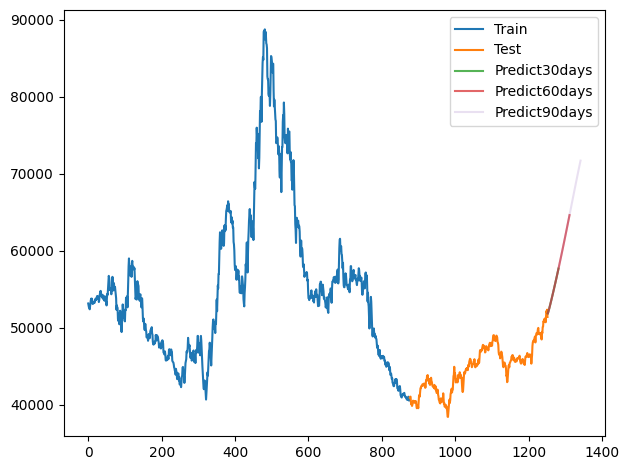

In [17]:
# 14.Vẽ hình
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#DXG
dxg_train_data_index = pd.RangeIndex(start=0, stop=dxg_train_size, step=1)
plt.plot(scaler.inverse_transform(dxg_train_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size, stop=dxg_train_size+dxg_test_size, step=1)
plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_test_data))
dxg_predict_data_30= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 30,step=1)
dxg_predict_data_60= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 60,step=1)
dxg_predict_data_90= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 90,step=1)
plt.plot(dxg_predict_data_30,scaler.inverse_transform(dxg_lst_output[:30]), alpha=0.8)
plt.plot(dxg_predict_data_60,scaler.inverse_transform(dxg_lst_output[:60]), alpha=0.7)
plt.plot(dxg_predict_data_90,scaler.inverse_transform(dxg_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()

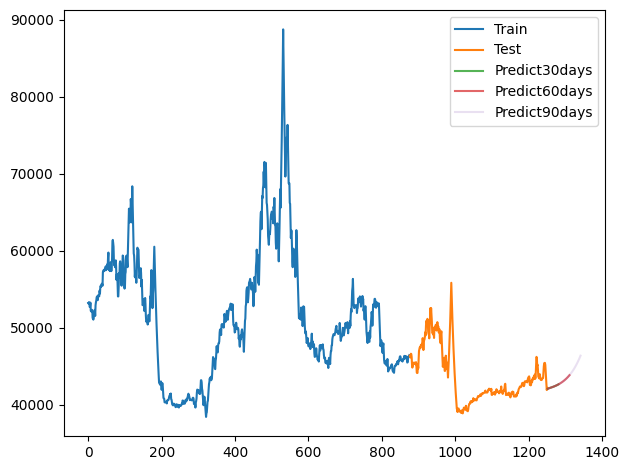

In [18]:
#qcg
qcg_train_data_index = pd.RangeIndex(start=0, stop=qcg_train_size, step=1)
plt.plot(scaler.inverse_transform(qcg_train_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size, stop=qcg_train_size+qcg_test_size, step=1)
plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_test_data))
qcg_predict_data_30= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 30,step=1)
qcg_predict_data_60= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 60,step=1)
qcg_predict_data_90= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 90,step=1)
plt.plot(qcg_predict_data_30,scaler.inverse_transform(qcg_lst_output[:30]), alpha=0.8)
plt.plot(qcg_predict_data_60,scaler.inverse_transform(qcg_lst_output[:60]), alpha=0.7)
plt.plot(qcg_predict_data_90,scaler.inverse_transform(qcg_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()

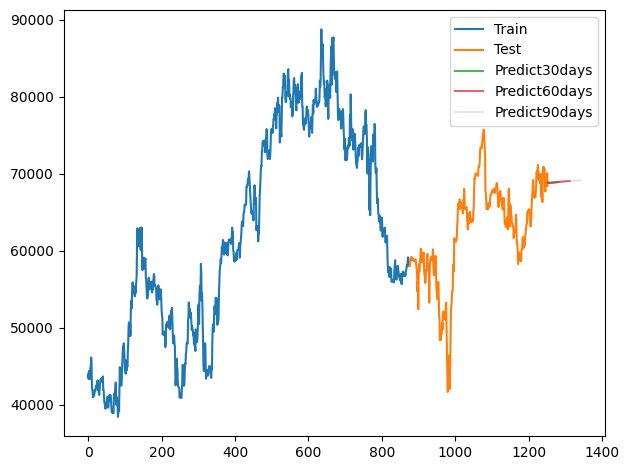

In [19]:
#DXG
vhm_train_data_index = pd.RangeIndex(start=0, stop=vhm_train_size, step=1)
plt.plot(scaler.inverse_transform(vhm_train_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size, stop=vhm_train_size+vhm_test_size, step=1)
plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_test_data))
vhm_predict_data_30= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 30,step=1)
vhm_predict_data_60= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 60,step=1)
vhm_predict_data_90= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 90,step=1)
plt.plot(vhm_predict_data_30,scaler.inverse_transform(vhm_lst_output[:30]), alpha=0.8)
plt.plot(vhm_predict_data_60,scaler.inverse_transform(vhm_lst_output[:60]), alpha=0.7)
plt.plot(vhm_predict_data_90,scaler.inverse_transform(vhm_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()